<a href="https://colab.research.google.com/github/truc14-nguyen/Hw1/blob/main/Final_nh%C3%B3m_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NHÓM 13: 
**- Ngô Thuỳ Vân** - MSSV:050608200760

**- Nguyễn Thị Thanh Trúc** - MSSV:050608200181

**- Nguyễn Lê Phương Vy** - MSSV:050608200781

Dữ liệu :https://drive.google.com/drive/u/0/folders/1QvTDHdQjy21MmYcQ8nQD-ig36BQakLP3

# CÂU 1: SPARK





In [ ]:
#cài đặt Spark 
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
openjdk-8-jdk-headless is already the newest version (8u362-ga-0ubuntu1~20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [ ]:
#import các thư viện cần dùng
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 400})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
#tạo session
conf = SparkConf().set("spark.ui.port", "4050")
#tạo context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

<IPython.core.display.Javascript object>

In [ ]:
def line_to_friend_ownership(line):
    split = line.split()
    user_id = int(split[0])
    if len(split) == 1:
        friends = []
    else:
        friends = list(map(lambda x: int(x), split[1].split(',')))
    return user_id, friends

def friend_ownership_to_connection(f_o):
    user_id = f_o[0]
    friends = f_o[1]
    connections = []
    for friend_id in friends:
        key = (user_id, friend_id)
        if user_id > friend_id:
            key = (friend_id, user_id)
        connections.append((key, 0))  #  # họ là bạn, value=0
    for friend_pair in itertools.combinations(friends, 2):
        friend_0 = friend_pair[0]
        friend_1 = friend_pair[1]
        key = (friend_0, friend_1)
        if friend_0 > friend_1:
            key = (friend_1, friend_0)
        connections.append((key, 1))  # họ có bạn chung, value=1
    return connections

def mutual_friend_count_to_recommendation(f):
    pair = f[0]
    friend0 = pair[0]
    friend1 = pair[1]
    noMutFriends = f[1]
    rec0 = (friend0, (friend1, noMutFriends))
    rec1 = (friend1, (friend0, noMutFriends))
    return [rec0, rec1]

def recommendation_to_sorted_truncated(recs):
    recs.sort(key=lambda x: (-x[1], x[0]))
    return list(map(lambda x: x[0], recs))[:10]

<IPython.core.display.Javascript object>

In [ ]:
# đọc dữ liệu dừ file
lines = sc.textFile("/content/drive/MyDrive/bigdata/Data/soc-LiveJournal1Adj.txt")


friend_ownership = lines.map(line_to_friend_ownership).filter(lambda friend: '' != friend[1])

#take 1000 samples for testing

# Map friend ownerships to instances of ((user_id, friend_id), VALUE).
# VALUE = 0 => các cặp đã là bạn bè.
# VALUE = 1 => các cặp có bạn chung.
friend_edges = friend_ownership.flatMap(friend_ownership_to_connection)
friend_edges.cache()

# lọc ra các cặp đã là bạn
mutual_friend = friend_edges.groupByKey() \
    .filter(lambda edge: 0 not in edge[1]) \
    .flatMap(lambda x: [(x[0],item) for item in x[1]]) # flat it to count total mutual friends No; use map directly causes bugs

# đếm những người bạn chung bằng cách cộng các giá trị
mutual_friend_counts = mutual_friend.reduceByKey( lambda x,y : x+y)

# tạo các đề xuất, nhóm chúng theo key, sau đó sắp xếp  
recommendations = mutual_friend_counts.flatMap(mutual_friend_count_to_recommendation).groupByKey() 

# # 10 người bạn được đề xuất cao nhất.
recommendations10 = recommendations.map(lambda m: (m[0], recommendation_to_sorted_truncated(list(m[1])))).sortByKey() 

# Include in your writeup the recommendations for the users with following user IDs: 924, 8941, 8942, 9019, 9020, 9021, 9022, 9990, 9992, 9993.
results = recommendations10.filter(lambda recommendations: recommendations[0] in [924, 8941, 8942, 9019, 9020, 9021, 9022, 9990, 9992, 9993])

<IPython.core.display.Javascript object>

In [ ]:
results.collect()

<IPython.core.display.Javascript object>

[(924, [439, 2409, 6995, 11860, 15416, 43748, 45881]),
 (8941, [8943, 8944, 8940]),
 (8942, [8939, 8940, 8943, 8944]),
 (9019, [9022, 317, 9023]),
 (9020, [9021, 9016, 9017, 9022, 317, 9023]),
 (9021, [9020, 9016, 9017, 9022, 317, 9023]),
 (9022, [9019, 9020, 9021, 317, 9016, 9017, 9023]),
 (9990, [13134, 13478, 13877, 34299, 34485, 34642, 37941]),
 (9992, [9987, 9989, 35667, 9991]),
 (9993, [9991, 13134, 13478, 13877, 34299, 34485, 34642, 37941])]

# CÂU 2


 **a) Một nhược điểm của việc sử dụng độ tin cậy (Confidence) đó là bỏ qua Pr(B). Đây là nhược điểm, vì sao? Giải thích tại sao Lift và Conviction không bị nhược điểm này?**

Nhược điểm: Confidence có sự bất cập là vì nó đã bỏ qua xác suất của Pr(B). Đôi khi Confidence có kết quả cao do tập mục A của luật kết hợp tương đối cao (ví dụ một cửa hàng bán quá nhiều A nhưng B lại ít thì Confidence tương đối cao), mà không phải do có mối quan hệ giữa 2 tập mục A và B. 

Theo đề bài, conf(A → B) = Pr(B|A). Trong đó, Pr(B|A) là xác suất có điều kiện của việc tìm thấy B nếu có A, công thức Pr(B|A) = Pr(A ∩ B)/ Pr(A). Ví dụ ta có luật kết hợp A -> B,  một cửa hàng bán 20 mặt hàng A và 100 mặt hàng B trong tổng số 1000 mặt hàng. Nhìn vào tử số thấy được Pr(A ∩ B) = 20/1000 và mẫu số Pr(A) = 20/1000, nên suy ra Confidence của luật kết hợp này bằng 1 nhưng nó lại không thể hiện mối quan hệ có ý nghĩa giữa mặt hàng A và mặt hàng B, mặt khác nó chỉ cho thấy B xuất hiện nhiều hơn A, mà Pr(B) = 100/1000 đã bị bỏ qua trong công thức. 

Trong khi Lift và Conviction lại có xác suất của cả 2 tập mục A và B trong công thức lift(A → B) = conf(A → B) /S(B) (conf có Pr(A) và S(B) = Pr(B) và tương tự với công thức conv); conv(A → B) = 1 − S(B)/ 1 − conf(A → B). Lấy một ví dụ minh họa về Lift và số liệu từ câu a) thì ta được Lift = 10, tức tỉ lệ 10:1, chứng tỏ A và B có mối quan hệ liên quan với nhau. Điều này giúp cho công thức có thể tránh được vấn đề thiên vị so với Confidence (Confidence đã loại bỏ Pr(B) khỏi công thức).  


**b) Một công thức là đối xứng nếu luật (A → B) = luật (B → A). Công thức nào được trình bày ở đây là đối xứng? Đối với mỗi công thức, hãy chứng minh cho thấy công thức đó là đối xứng hoặc một ví dụ biện chứng cho thấy công thức đó không đối xứng.**

Lift is symmetrical. Confidence and conviction are not since confidence and conviction are directional but lift is not. 
1. lift(A→B) = lift(B→A) = Pr(A ∩ B)/ Pr(A) x Pr(B). 
2. conf(A→B) = Pr(B|A) and conf(B→A) = Pr(A|B).Pr(A|B) and Pr(B|A) might be different.
3. conv is based on conf and is directional.
Example:
If we have baskets AB, AC, AD, then S(A) = 3/3, S(B) = 1/3, and Pr(A, B) = 1/3.
Then conf(A→B)=Pr(B|A) ≠ Pr(A|B)= conf(B→A) since: ⅓: 3/3  ≠  ⅓:1/3.
Similarly, conv(A→B)= 1−S(B)/ 1−conf(A→B) khác 1−S(A)/ 1−conf(B→A)= conv(B→A) since: 1−1/3:1−1/2= 4/3 khác 1−2/3: 1−1= inf


Lift là đối xứng (luật A→B = luật B→A), còn confidence và conviction thì không phải. Ta suy ra từ công thức: 

1. lift(A→B) = lift(B→A) =  Pr(A ∩ B)/ Pr(A) x Pr(B). 
2. conf(A→B) = Pr(B|A) và conf(B→A) = Pr(A|B). Pr(A|B) và Pr(B|A) có thể khác nhau.
3. conv dựa trên conf và có tính định hướng.

Ví dụ:
Nếu ta có các rổ AB, AC, AD, AE thì S(A) = 4/4, S(B) = 1/4 và Pr(A ∩ B) = 1/4 
Khi đó conf(A→B) = Pr(B|A) ≠ Pr(A|B) = conf(B→A) vì: 1/4: 4/4  ≠ 1/4:1/4.
Tương tự, conv(A→B) = 1−S(B)/ 1−conf(A→B) ≠ 1−S(A)/ 1−conf(B→A) = conv(B→A) vì: 1 −1/4 : 1−1/4 = 1 ≠ 1− 4/4 : 1−1= inf. Vậy nên, chỉ có công thức Lift thỏa mãn được luật A→B = luật B→A.




**c) Hàm ý hoàn hảo là các quy tắc giữ đúng 100% thời gian (hoặc tương đương, xác suất có điều kiện liên quan là 1). Một công thức được thỏa mãn nếu nó đạt đến giá trị tối đa có thể đạt được cho tất cả các hàm ý hoàn hảo. Điều này giúp dễ dàng xác định các công thức tốt nhất. Công thức nào trong số các công thức trên có tính chất này? Bạn có thể bỏ qua 0/0 nhưng không thể bỏ qua các trường hợp vô cực khác. Ngoài ra, bạn có thể dễ dàng giải thích bằng một ví dụ.**
Conviction and confidence are desirable while lift is not. If B occurs every
time A occurs (i.e, Pr(B|A) = 1) then
1. conf(A→B) = 1
2. conv(A→B)→infinity
3. lift(A→B) depends on the value of Pr(B)and may differ as B might occur in baskets which do not have A.
Example:
If we have baskets AB, AB, CD, EF, then Pr(B|A) = 1,S(B) = 1/2,Pr(D|C) = 1, and S(D) = 1/4.
Then lift(A→B) = 1 : 1/2= 2 and lift(C→D) = 1:1/4= 4. Although both rules are 100% rules, they have different lift scores.

Conviction và confidence thỏa mãn được trong khi lift thì không. Nếu B xảy ra mỗi thời điểm A xảy ra (nghĩa là Pr(B|A) = 1) thì: 
1. conf(A→B) = 1
2. conv(A→B)→infinity
3. lift(A→B) phụ thuộc vào giá trị của Pr(B) và có thể khác vì B có thể xảy ra trong các giỏ không có A.
Ví dụ:
Nếu chúng ta có các rổ AB, AB, CD, EF thì Pr(B|A) = 1, S(B) = 1/2, Pr(D|C) = 1, và S(D) = 1/4.
Sau đó, lift(A→B) = 1 : 1/2= 2 và lift(C→D) = 1:1/4= 4. Mặc dù cả hai quy tắc đều là quy tắc 100% nhưng chúng có tỉ lệ lift khác nhau.


In [ ]:
from pyspark.sql import SparkSession
from functools import partial
from itertools import combinations

<IPython.core.display.Javascript object>

**Câu d:**

In [ ]:

if __name__=='__main__':
    spark = SparkSession.builder.getOrCreate()
    sc = spark.sparkContext
    lines=sc.textFile('/content/drive/MyDrive/bigdata/Data/browsing.txt')

    frequent_items=lines.flatMap(lambda l:l.split()).map(lambda ele:(ele,1)).\
        reduceByKey(lambda e1,e2:e1+e2).filter(lambda x:x[1]>=100)

    frequent_itemset=frequent_items.collectAsMap()

    frequent_pairs = lines.map(lambda l: l.split()).flatMap(partial(combinations, r=2)).map(lambda pair: sorted(pair)) \
        .map(lambda pair: (tuple(pair), 1)).filter(
        lambda ele: ele[0][0] in frequent_itemset and ele[0][1] in frequent_itemset).reduceByKey(
        lambda p1, p2: p1 + p2).filter(lambda x: x[1] >= 100)

    freq_pairs_count=frequent_pairs.collectAsMap()

    frequent_pairs=frequent_pairs.flatMap(lambda ele:[((ele[0][0],ele[0][1]),ele[1]),((ele[0][1],ele[0][0]),ele[1])])

    frequent_pair_conf=frequent_pairs.map(lambda ele:(ele[0],float(ele[1]/frequent_itemset[ele[0][0]]))).sortBy(lambda x:-x[1])

    frequent_pair_conf.toDF().show(10) 

<IPython.core.display.Javascript object>

+--------------------+------------------+
|                  _1|                _2|
+--------------------+------------------+
|{DAI93865, FRO40251}|               1.0|
|{GRO85051, FRO40251}| 0.999176276771005|
|{GRO38636, FRO40251}|0.9906542056074766|
|{ELE12951, FRO40251}|0.9905660377358491|
|{DAI88079, FRO40251}|0.9867256637168141|
|{FRO92469, FRO40251}| 0.983510011778563|
|{DAI43868, SNA82528}| 0.972972972972973|
|{DAI23334, DAI62779}|0.9545454545454546|
|{ELE92920, DAI62779}|0.7326649958228906|
|{DAI53152, FRO40251}| 0.717948717948718|
+--------------------+------------------+
only showing top 10 rows



**Câu e: Top 5 rules with confidence scores** 

In [ ]:

triples=lines.map(lambda l:l.split()).flatMap(partial(combinations,r=3)).map(lambda triple:tuple(list(sorted(triple))))

triples=triples.map(lambda triple:(triple,1)).reduceByKey(lambda t1,t2:t1+t2).filter(lambda x:x[1]>=100)

freq_triples_conf=triples.flatMap(lambda ele:[(((ele[0][0],ele[0][1]),ele[0][2]),ele[1]),
                                                  (((ele[0][0],ele[0][2]),ele[0][1]),ele[1]),
                                                  (((ele[0][1],ele[0][2]),ele[0][0]),ele[1])])\
.reduceByKey(lambda t1,t2:t1+t2).map(lambda ele:(ele[0],ele[1]/freq_pairs_count[ele[0][0]])).sortBy(lambda x:(-x[1],x[0][0],x[0][1]))\
                        .map(lambda ele:(ele[0][0],ele[0][1],ele[1]))
freq_triples_conf.toDF().show(10) 

<IPython.core.display.Javascript object>

+--------------------+--------+---+
|                  _1|      _2| _3|
+--------------------+--------+---+
|{DAI23334, ELE92920}|DAI62779|1.0|
|{DAI31081, GRO85051}|FRO40251|1.0|
|{DAI55911, GRO85051}|FRO40251|1.0|
|{DAI62779, DAI88079}|FRO40251|1.0|
|{DAI75645, GRO85051}|FRO40251|1.0|
|{ELE17451, GRO85051}|FRO40251|1.0|
|{ELE20847, FRO92469}|FRO40251|1.0|
|{ELE20847, GRO85051}|FRO40251|1.0|
|{ELE26917, GRO85051}|FRO40251|1.0|
|{FRO53271, GRO85051}|FRO40251|1.0|
+--------------------+--------+---+
only showing top 10 rows



# Câu 3

Số cột có m phần tử 1 trên tổng số n cột là ${n \choose m}$. Số lượng cột đó mà không có số 1 trong & hàng được chọn là ${n-k \choose m}$.
Xác suất để chọn được cột đó là: ${n-k \choose m}/{n \choose m}$.
Do đó, xác suất để đạt được "don't know" khi minhashing cho cột đó là 1 trên tổng số ${n \choose m}$ trường hợp cột, tức là:




Số cột có m phần tử 1 trên tổng số n cột là ${n \choose m}$. Số lượng cột đó mà không có số 1 trong & hàng được chọn là ${n-k \choose m}$.
Xác suất để chọn được cột đó là: $\displaystyle\frac{n-k \choose m}{n \choose m}$.
Do đó, xác suất để đạt được "don't know" khi minhashing cho cột đó là 1 trên tổng số ${n \choose m}$ trường hợp cột, tức là:

P(don't know)=${\displaystyle\frac{(n-k) \choose m}{n\choose m}}$ + $\displaystyle\frac{(n-k)!m!(n-m)!}{m!(n-k-m)!n!}$+ $\displaystyle\frac{(n-k)*(n-k-1)...(n-k-m+1)} {n*(n-1)...(n-m+1)}$
Để giới hạn xác suất này, ta có thể sử dụng bất đẳng thức AM- GM:
$\displaystyle\frac{(n - k) + (n - k - 1) + \cdots + (n - k - m + 1)}{m} \ge \sqrt[m]{(n - k) * (n - k - 1) \cdots (n - k - m + 1}$

Hay:
$(n - k - m + 1)*(n - k - m + 2)\cdots(n - k) \le (\displaystyle\frac{n - k}{m})^m$ $n^m$

Do đó:

$P(\text{don't know}) = \displaystyle\frac{(n -k)*(n -k-1)\cdots(n -k-m + 1)}{n*(n-1)\cdots(n-m+1)} \le (\displaystyle\frac{n - k}{n})^m$

Vì vậy, xác suất tối đa để đạt được "don't know" là $\left(\frac{n-k}{n}\right)^m$.

Với giá trị $e^{-10}$, ta có: $(\displaystyle\frac{n-k}{n})^m \le e^{-10}$

Tương đương với: $(1 - \displaystyle\frac{k}{n})^m \le e^{-10}$

Do $1-x \le e^{-x}$, ta có: $x^{\displaystyle\frac{-km}{n}} = e^{-10}$



**c)**

Câu hỏi đưa ra yêu cầu chúng ta cung cấp một ví dụ về hai cột (tương ứng với hai tập hợp) sao cho xác suất để giá trị minhash của chúng giống nhau không bằng giá trị của hệ số tương đồng Jaccard của chúng, khi ta chỉ xem xét các hoán vị tuần hoàn.

Giải pháp cho câu hỏi được cung cấp như sau:

(a) Hai cột (tập hợp) là:

css
Copy code
[0 1 0]^T và [0 1 1]^T
(b) Giá trị hệ số tương đồng Jaccard giữa S1 và S2 là:

javascript
Copy code
J(S1, S2) = |S1 ∩ S2| / |S1 ∪ S2| = 1/2
(c) Xác suất để một hoán vị tuần hoàn ngẫu nhiên cho giá trị minhash giống nhau cho cả S1 và S2 là:

less
Copy code
P(minhash(S1) = minhash(S2) | cyclic permutations) = 2/3
Giải thích:

Khi chỉ xem xét các hoán vị tuần hoàn, chỉ có ba hoán vị có thể xảy ra: (1,2,3), (2,3,1), và (3,1,2). Nếu chúng ta bắt đầu chu kỳ tại hàng đầu tiên hoặc thứ hai (1 hoặc 2), giá trị minhash của S1 và S2 sẽ giống nhau. Tuy nhiên, nếu chúng ta bắt đầu chu kỳ tại hàng cuối cùng (3), giá trị minhash sẽ khác nhau. Do đó, xác suất của giá trị minhash giống nhau là 2/3.

# CÂU 4




**a)**
Trước hết, chúng ta xác định các tập hợp Wj và T như đã đề cập trong câu hỏi. Đối với mỗi hàm băm gj, tập hợp Wj chứa tất cả các điểm dữ liệu mà ánh xạ đến cùng một giá trị như điểm truy vấn z, và tập hợp T chứa tất cả các điểm dữ liệu cách z hơn cλ. Chúng ta muốn chứng minh rằng xác suất tìm thấy nhiều hơn 3L điểm dữ liệu trong phần giao giữa T và mỗi Wj là nhỏ.

Giải pháp đã cho cung cấp một giới hạn trên kích thước kỳ vọng của sự giao giữa T và mỗi Wj. Cụ thể, đối với mỗi 1≤ j ≤ L, chúng ta có:

Pr[x∈T∩Wj] ≤ p${k \choose 2}$ = $\displaystyle\frac{1}{n}$,

Điều đó có nghĩa là xác suất một điểm dữ liệu bất kỳ x nằm cùng trong T và Wj không quá $\displaystyle\frac{1}{n}$. Do đó, chúng ta có thể viết:

E[|T ∩ Wj|] = ∑x∈A Pr[x∈T ∩ Wj] ≤ ∑x∈A Pr[x∈T] Pr[x∈Wj] ≤ pk2 = $\displaystyle\frac{1}{n}$.

Sử dụng tính tuyến tính của kỳ vọng, chúng ta có:
 
E[∑j=1LE[PLj=1 |T ∩ Wj|]] ≤ LE[|T ∩ Wj|] ≤ $\displaystyle\frac{L}{n}$.

Bây giờ, chúng ta có thể áp dụng bất đẳng thức Markov để có được:

Pr[∑j=1L|T ∩ Wj| > 3L] ≤ E[∑j=1L|T ∩ Wj|]/3L ≤ $\displaystyle\frac{1}{3}$.

Do đó, xác suất tìm thấy nhiều hơn 3L điểm dữ liệu trong phần giao giữa T và mỗi Wj không quá $\displaystyle\frac{1}{3}$, điều đó có nghĩa là với xác suất ít nhất là $\displaystyle\frac{2}{3}$, chúng ta sẽ không tìm thấy nhiều hơn 3L điểm dữ liệu như vậy. Điều này hoàn thành bằng chứng.


**a)**

Trước hết, chúng ta xác định các tập hợp Wj và T như đã đề cập trong câu hỏi. Đối với mỗi hàm băm gj, tập hợp Wj chứa tất cả các điểm dữ liệu mà ánh xạ đến cùng một giá trị như điểm truy vấn z, và tập hợp T chứa tất cả các điểm dữ liệu cách z hơn cλ. Chúng ta muốn chứng minh rằng xác suất tìm thấy nhiều hơn 3L điểm dữ liệu trong phần giao giữa T và mỗi Wj là nhỏ.

Giải pháp đã cho cung cấp một giới hạn trên kích thước kỳ vọng của sự giao giữa T và mỗi Wj. Cụ thể, đối với mỗi j, chúng ta có:

Pr[x∈TTWj]≤pk2=1/n,

Điều đó có nghĩa là xác suất một điểm dữ liệu bất kỳ x nằm cùng trong T và Wj không quá 1/n. Do đó, chúng ta có thể viết:

E[|T ∩ Wj|] = ∑x∈A Pr[x∈T ∩ Wj] ≤ ∑x∈A Pr[x∈T] Pr[x∈Wj] ≤ pk2 = 1/n.

Sử dụng tính tuyến tính của kỳ vọng, chúng ta có:
 
E[∑j=1LE[PLj=1 |T ∩ Wj|]] ≤ LE[|T ∩ Wj|] ≤ L/n.

Bây giờ, chúng ta có thể áp dụng bất đẳng thức Markov để có được:


Pr[∑j=1L|T ∩ Wj| > 3L] ≤ E[∑j=1L|T ∩ Wj|]/3L ≤ 1/3.


Do đó, xác suất tìm thấy nhiều hơn 3L điểm dữ liệu trong phần giao giữa T và mỗi Wj không quá 1/3, điều đó có nghĩa là với xác suất ít nhất là 2/3, chúng ta sẽ không tìm thấy nhiều hơn 3L điểm dữ liệu như vậy. Điều này hoàn thành bằng chứng.



**b)**

Để chứng minh: Pr [∀ 1 ≤ j ≤ L, gj($x^{*}$
) ≠ gj(z)] < $\displaystyle\frac{1}{e}$

Trong đó $x^{*}$
 là một điểm trong A sao cho d($x^{*}$, z) ≤ λ.

Để làm được điều này, ta có thể bắt đầu bằng việc sử dụng sự thật rằng đối với bất kỳ 1 ≤ j ≤ L nào, ta có:

Pr[gj($x^{*}$) = gj(z)] ≥ pk1

Trong đó pk1 là xác suất rằng gj($x^{*}$) = gj(z), được định nghĩa trong câu hỏi.

Ta có thể sử dụng bất đẳng thức trên để thu được một giới hạn trên cho xác suất rằng gj($x^{*}$) ≠ gj(z), như sau:

Pr[gj($x^{*}$) ≠ gj(z)] ≤ 1 - Pr[gj($x^{*}$) = gj(z)] 

≤ 1 - pk1

= 1 - $p^{\displaystyle\frac{log1}{p2(n)}}$) _ 1 (thay thế pk1 bằng định nghĩa của nó) 

= 1 - $(\displaystyle\frac{1}{n})^{\displaystyle\frac{log1}{p2(n)}}$

= 1 - $(\displaystyle\frac{1}{n})^{p}$
 (với ρ = log($\displaystyle\frac{1}{p1}$) / log($\displaystyle\frac{1}{p2}$))

= 1 - $\displaystyle\frac{1}{L}$

= $\displaystyle\frac{(L-1)}{L}$

trong đó ta đã sử dụng thực tế rằng k = $\displaystyle\frac{log1}{p2(n)}$, do đó L = $n^{p}$.

Tiếp theo, ta có thể sử dụng bất đẳng thức trên để thu được một giới hạn trên cho xác suất rằng tất cả các gj đều thỏa mãn gj($x^{*}$) ≠ gj(z), như sau:

Pr [∀ 1 ≤ j ≤ L, gj($x^{*}$) ≠ gj(z)] 

≤ ∏_{j=1}^L Pr[gj($x^{*}$) ≠ gj(z)] (sử dụng kết hợp liên minh) 

≤ $(\displaystyle\frac{L-1}{L})^{L}$ 

≤ $e^{-1}$

Trong đó ta đã sử dụng thực tế rằng (1 - $\displaystyle\frac{1}{L})^{L}$ ≤ $\displaystyle\frac{1}{e}$ cho bất kỳ số nguyên dương L nào.

Do đó, ta đã chứng minh được rằng:

Pr [∀ 1 ≤ j ≤ L, gj($x^{*}$) ≠ gj(z)] < $\displaystyle\frac{1}{e}$

**c)**


Để kết luận rằng với xác suất lớn hơn một hằng số cố định thì điểm được báo cáo là một (c, λ)-ANN thực sự, chúng ta cần chỉ ra rằng xác suất thất bại được giới hạn bởi một hằng số. Điều này có thể thực hiện bằng cách kết hợp kết quả từ phần (a) và phần (b).

Giả sử $x^{*}$ là hàng xóm gần nhất thực sự với điểm truy vấn z với khoảng cách d ($x^{*}$, z) ≤ λ. Từ phần (b), chúng ta biết rằng với xác suất ít nhất là 1 - $\displaystyle\frac{1}{e}$, $x^{*}$ được băm vào ít nhất một trong L thùng mà điểm truy vấn băm vào, tức là tồn tại một hàm băm gj sao cho gj ($x^{*}$) = gj (z).
Bây giờ, hãy để Wj là tập hợp các điểm dữ liệu được ánh xạ đến cùng một thùng như điểm truy vấn z bằng cách sử dụng hàm băm gj, như được định nghĩa trong phần (a). Hãy để T là tập hợp các điểm dữ liệu cách điểm truy vấn xa hơn cλ. Từ phần (a), chúng ta biết rằng xác suất của ít nhất 3L điểm dữ liệu nằm trong phần giao của T và Wj cho một số j nhỏ hơn hoặc bằng $\displaystyle\frac{1}{3}$.
Giả sử rằng $x^{*}$ được băm vào ít nhất một trong L thùng mà điểm truy vấn băm vào, chúng ta cần xem xét hai trường hợp:
Trường hợp 1: $x^{*}$ không nằm trong phần giao của T và bất kỳ Wj nào. Trong trường hợp này, thuật toán sẽ trả về $x^{*}$, đó là hàng xóm gần nhất thực sự với điểm truy vấn với khoảng cách d ($x^{*}$, z) ≤ λ.
Trường hợp 2: $x^{*}$ nằm trong phần giao của T và một số Wj. Trong trường hợp này, thuật toán có thể trả về một điểm không phải là hàng xóm gần nhất thực sự với điểm truy vấn. Tuy nhiên, xác suất của việc này có thể được giới hạn như sau:
Giả sử Yj là biến chỉ mục có giá trị bằng 1 nếu có ít nhất 3 điểm dữ liệu nằm trong giao của T và Wj, và bằng 0 nếu không. Khi đó, xác suất thất bại của thuật toán có thể được biểu diễn như sau:
Pr[thuật toán thất bại] = Pr[$x^{*}$ nằm trong giao của T và một số Wj] × Pr[thuật toán chọn một điểm không phải $x^{*}$ từ giao này]
Sử dụng bất đẳng thức liên hợp và kết quả từ phần (a), ta có:
Pr[$x^{*}$ nằm trong giao của T và một số Wj] ≤ Σj Pr[Yj = 1] ≤ Σj Pr[3L điểm dữ liệu nằm trong T và Wj] ≤ L($\displaystyle\frac{1}{3}$) = ρlog($\displaystyle\frac{1}{p1}$)
Ở đây, bất đẳng thức cuối cùng được suy ra từ định nghĩa của ρ trong thủ tục.
Giờ đây, giả sử Zj là biến chỉ mục có giá trị bằng 1 nếu thuật toán chọn một điểm không phải $x^{*}$ từ giao của T và Wj, và bằng 0 nếu không. Khi đó, xác suất chọn một điểm không phải $x^{*}$ từ giao của T và Wj có thể được biểu diễn như sau:
Pr[thuật toán chọn một điểm không phải $x^{*}$ từ giao này] = Σj Pr[Zj = 1]
Vì các điểm dữ liệu được chọn đồng đều ngẫu nhiên từ giao của T và Wj, nên xác suất chọn một điểm không phải $x^{*}$ bị chặn dưới bởi (|T ∩ Wj| - 1) / |T ∩ Wj|. Do đó, ta có:
Pr[Zj = 1] ≤ (|T ∩ Wj| - 1) / |T ∩ Wj| ≤ 1 - 1/|T ∩ Wj|
Sử dụng bất đẳng thức liên hợp một lần nữa, ta có:
Pr[thuật toán thất bại] ≤ Pr[$x^{*}$ nằm trong giao của T và một số Wj] × Pr[thuật toán chọn một điểm không phải $x^{*}$ từ giao này]



**câu d**

In [ ]:
#Liên kết Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import numpy as np
#import random
import time
#import pdb
import unittest
from PIL import Image

#tìm khoảng cách L1 giữa 2 vector
#u,v là các np.array 1 chiều
def l1(u, v):
    return  np.abs(u-v).sum()
#nạp dữ liệu vào mảng
def load_data(filename):
    return np.genfromtxt(filename, delimiter=',')
# tạo hàm băm từ danh sách kích thước chiều và ngưỡng
def create_function(dimensions, thresholds):
    def f(v):
        boolarray = [v[dimensions[i]] >= thresholds[i] for i in range(len(dimensions))]
        return "".join(map(str, map(int, boolarray)))
    return f

def create_functions(k, L, num_dimensions=400, min_threshold=0, max_threshold=255):
    functions = []
    for i in range(L):
        dimensions = np.random.randint(low = 0, 
                                   high = num_dimensions,
                                   size = k)
        thresholds = np.random.randint(low = min_threshold, 
                                   high = max_threshold + 1, 
                                   size = k)

        functions.append(create_function(dimensions, thresholds))
    return functions

def hash_vector(functions, v):
    return np.array([f(v) for f in functions])

def hash_data(functions, A):
    return np.array(list(map(lambda v: hash_vector(functions, v), A)))

def get_candidates(hashed_A, hashed_point, query_index):
    return filter(lambda i: i != query_index and \
        any(hashed_point == hashed_A[i]), range(len(hashed_A)))

def lsh_setup(A, k = 24, L = 10):
    functions = create_functions(k = k, L = L)
    hashed_A = hash_data(functions, A)
    return (functions, hashed_A)

def lsh_search(A, hashed_A, functions, query_index, num_neighbors = 10):
    hashed_point = hash_vector(functions, A[query_index, :])
    candidate_row_nums = get_candidates(hashed_A, hashed_point, query_index)
    
    distances = map(lambda r: (r, l1(A[r], A[query_index])), candidate_row_nums)
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]

    return [t[0] for t in best_neighbors]

def plot(A, row_nums, base_filename):
    for row_num in row_nums:
        patch = np.reshape(A[row_num, :], [20, 20])
        im = Image.fromarray(patch)
        if im.mode != 'RGB':
            im = im.convert('RGB')
        im.save(base_filename + "-" + str(row_num) + ".png")

def linear_search(A, query_index, num_neighbors):
    distances=  ( (r, l1(A[r], A[query_index])) for r in   range(len(A))  if r != query_index )
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]
    
    return [t[0] for t in best_neighbors]
    
     #TODO

from functools import reduce
def measure_error(A,query_index,lsh_result: np.ndarray,linear_result:np.ndarray):
    def sub_measure(result): 
        return reduce(lambda a,b: a+b,
                      map(lambda r:  l1(A[r],A[query_index]),result),0. )
    return sub_measure(lsh_result)/sub_measure(linear_result)

In [ ]:
from matplotlib import pyplot as plt

def plot_error_change(file_path):   
    A= load_data(file_path)
    def geterror(k=24,L =10):
        error =0.
        functions, hashed_A = lsh_setup(A, k = k, L = L)
        for query_index in range(100,1100,100):
            lsh_result =  lsh_search(A, hashed_A, functions, query_index, num_neighbors = 3)
            linear_result =  linear_search( A,query_index,num_neighbors=3)
            error += measure_error(A,query_index,lsh_result,linear_result)
        return error/10
    
    
    x_L= range(10,22,2)
    x_K= range(16,26,2)
    y_L= [ geterror(L=l)  for l in x_L ]
    y_K= [geterror(k=k)  for k in x_K  ]
    plt.subplot(2,1,1)
    plt.title('K=24')
    plt.xlabel("L")
    plt.ylabel("error")
    plt.plot(x_L,y_L)
    
    plt.subplot(2,1,2)
    plt.title('L=10')
    plt.xlabel("K")
    plt.ylabel("error")
    plt.plot(x_K,y_K)
    plt.show()
    return (y_L,y_K)

In [ ]:
# TODO: Solve Problem 4
def problem4():
    y_L ,y_K  =  plot_error_change ('/content/drive/MyDrive/bigdata/Data/patches.csv')
    A= load_data('/content/drive/MyDrive/bigdata/Data/patches.csv') #please change this url to your folder which contains patches.csv file
    functions, hashed_A = lsh_setup(A)
    query_index= 100
    lsh_result =  lsh_search(A, hashed_A, functions, query_index, num_neighbors = 10)
    linear_result =  linear_search( A,query_index,num_neighbors=10)
    plot(A,lsh_result,'LSH')
    plot(A,linear_result,'LINEAR')  
    plot(A,[100],'RAW')

    return  y_L ,y_K

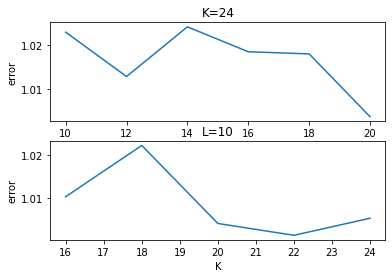

([1.0229792786838685,
  1.0128665818201066,
  1.0241840360633165,
  1.0185060073687162,
  1.018022755730564,
  1.0037080215151337],
 [1.010327898616743,
  1.0221166906900812,
  1.0041797021437895,
  1.0014553976404688,
  1.0053805386471786])

In [ ]:
problem4()